In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import graclus, pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
ages = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")  # Shape: (592,)
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")  # Shape: (592, R, F)
plv_tensor = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")  # Shape: (592, R, R)
region_list = pd.read_csv("Downloads/DL_Project/HCP-MMP1_UniqueRegionList.csv")

In [3]:
region_list

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STSva_R,Area_STSv_anterior_R,376_R,R,STSva,Temp,Auditory_Association,376,11,32.924419,117.527907,54.337791,1720
356,TE1m_R,Area_TE1_Middle_R,377_R,R,TE1m,Temp,Lateral_Temporal,377,14,26.146605,102.236497,53.246528,2592
357,PI_R,Para-Insular_Area_R,378_R,R,PI,Temp,Insular_and_Frontal_Opercular,378,12,47.013363,123.157016,57.926503,898
358,a32pr_R,Area_anterior_32_prime_R,379_R,R,a32pr,Fr,Anterior_Cingulate_and_Medial_Prefrontal,379,19,81.723096,153.990326,102.516324,827


In [4]:
print(f"Ages Shape: {ages.shape}, Range: {ages.min()}-{ages.max()}")
print(f"Node Features Shape: {features.shape}")
print(f"PLV Tensor Shape: {plv_tensor.shape}")

Ages Shape: (587,), Range: 18.5-88.92
Node Features Shape: (2, 587, 360)
PLV Tensor Shape: (587, 360, 360)


In [5]:
print(region_list.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionName      360 non-null    object 
 1   regionLongName  360 non-null    object 
 2   regionIdLabel   360 non-null    object 
 3   LR              360 non-null    object 
 4   region          360 non-null    object 
 5   Lobe            360 non-null    object 
 6   cortex          360 non-null    object 
 7   regionID        360 non-null    int64  
 8   Cortex_ID       360 non-null    int64  
 9   x-cog           360 non-null    float64
 10  y-cog           360 non-null    float64
 11  z-cog           360 non-null    float64
 12  volmm           360 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 36.7+ KB
None


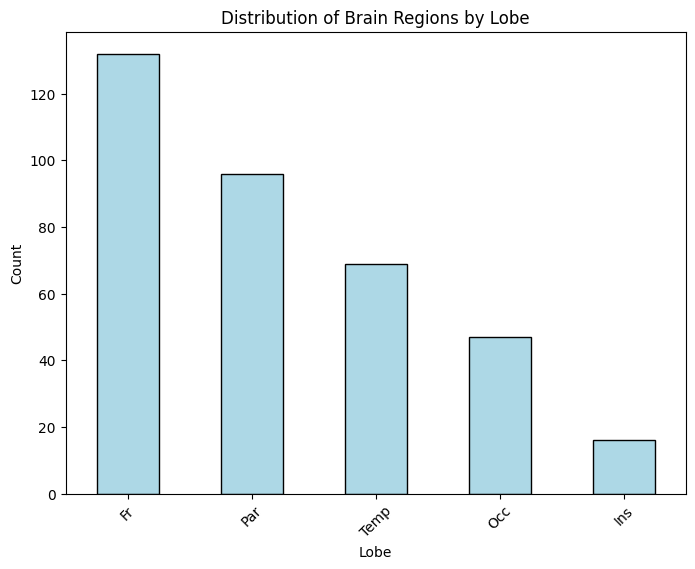

In [6]:
lobe_counts = region_list["Lobe"].value_counts()

plt.figure(figsize=(8, 6))
lobe_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribution of Brain Regions by Lobe")
plt.xlabel("Lobe")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

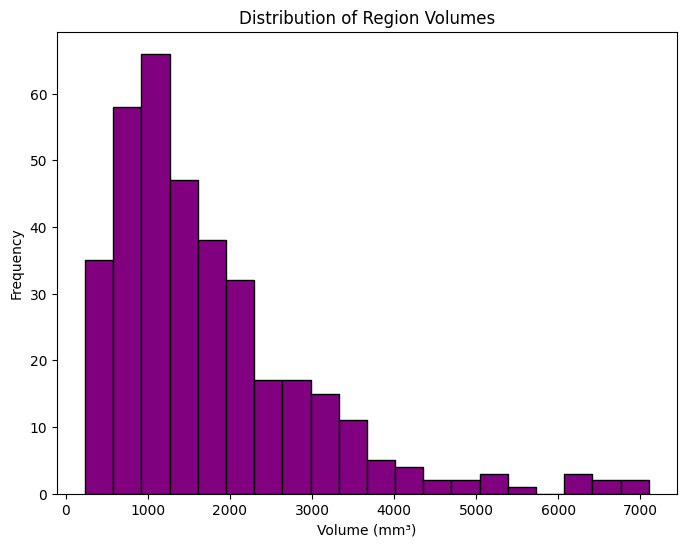

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(region_list["volmm"], bins=20, color='purple', edgecolor='black')
plt.title("Distribution of Region Volumes")
plt.xlabel("Volume (mm³)")
plt.ylabel("Frequency")
plt.show()

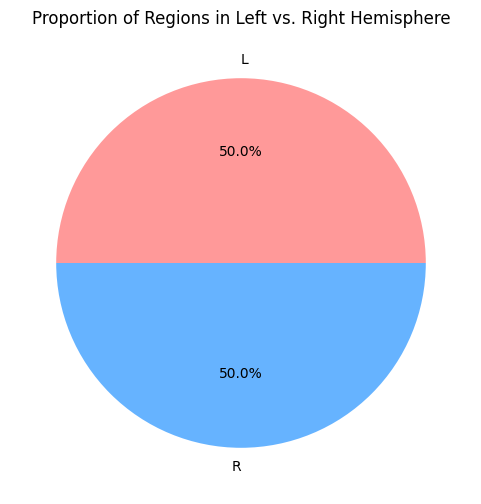

In [9]:
hemisphere_counts = region_list["LR"].value_counts()

plt.figure(figsize=(6, 6))
hemisphere_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Proportion of Regions in Left vs. Right Hemisphere")
plt.ylabel("")
plt.show()

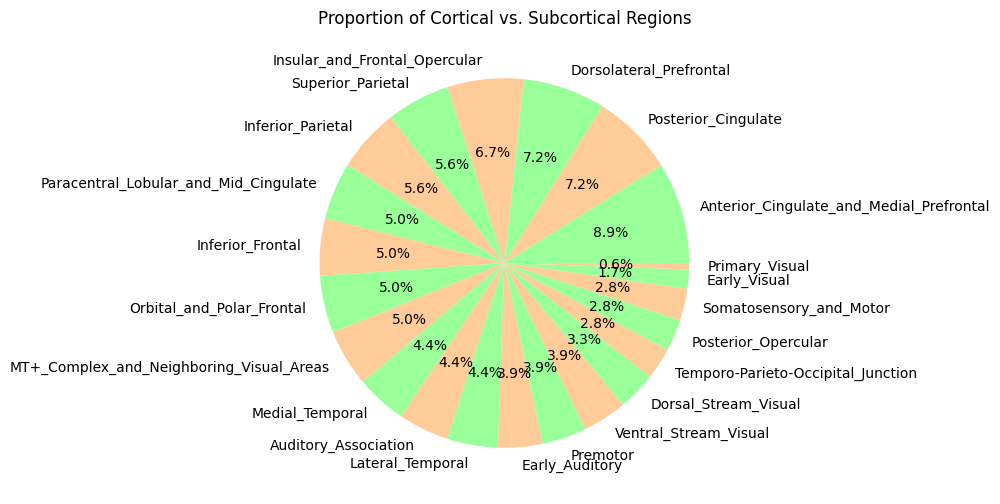

In [10]:
cortex_counts = region_list["cortex"].value_counts()

plt.figure(figsize=(6, 6))
cortex_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#99ff99','#ffcc99'])
plt.title("Proportion of Cortical vs. Subcortical Regions")
plt.ylabel("")
plt.show()

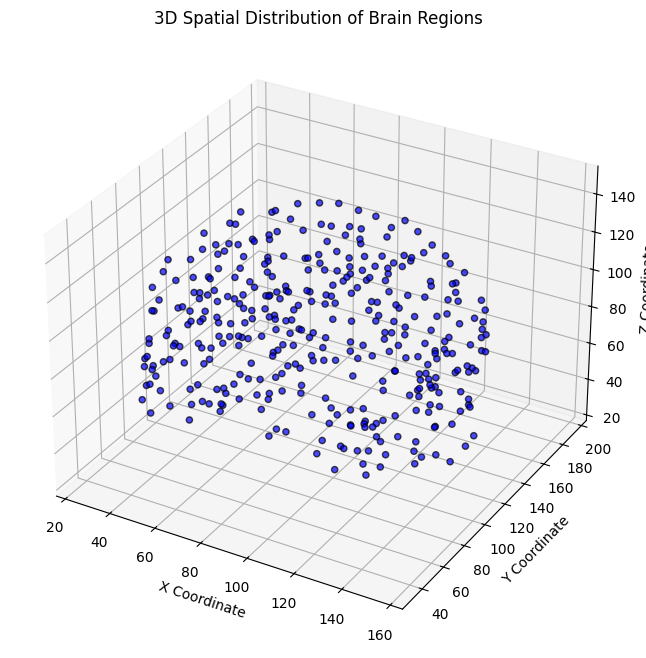

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(region_list["x-cog"], region_list["y-cog"], region_list["z-cog"], 
           c='blue', alpha=0.7, edgecolor='black')
ax.set_title("3D Spatial Distribution of Brain Regions")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
plt.show()

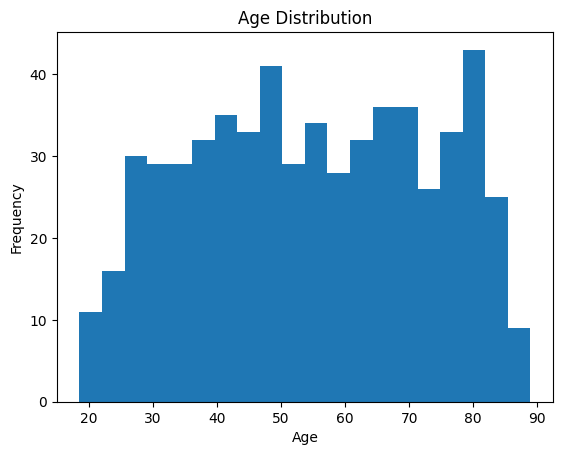

In [13]:
plt.hist(ages, bins=20,)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

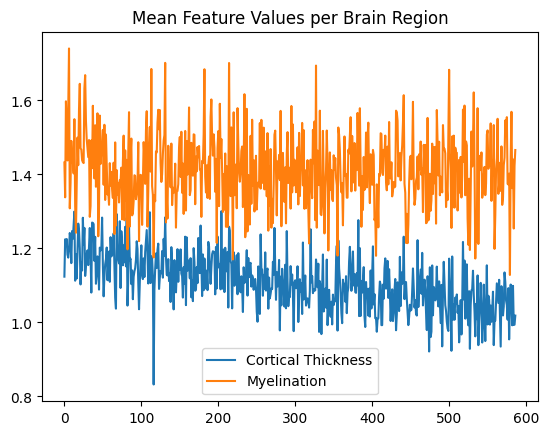

In [14]:
mean_thickness = features[:, :, 0].mean(axis=0)  # Assuming 0th feature is thickness
mean_myelination = features[:, :, 1].mean(axis=0)  # Assuming 1st feature is myelination

plt.plot(mean_thickness, label="Cortical Thickness")
plt.plot(mean_myelination, label="Myelination")
plt.legend()
plt.title("Mean Feature Values per Brain Region")
plt.show()

In [29]:
features

array([[[1.8762962 , 2.48600174, 2.2195392 , ..., 3.66976392,
         2.97760107, 2.97711001],
        [2.09062645, 2.29132107, 2.22712653, ..., 3.28923072,
         3.10494176, 3.00573773],
        [2.03862124, 2.82578408, 2.31156045, ..., 3.5173097 ,
         3.04571691, 2.98873463],
        ...,
        [1.69124181, 2.19632759, 1.74408614, ..., 2.52285154,
         2.91029209, 3.22168942],
        [1.65712728, 2.4562041 , 2.30820821, ..., 2.92478084,
         2.72510105, 2.55027274],
        [1.74728375, 2.63190422, 2.21468002, ..., 3.09983418,
         2.95683506, 2.90451282]],

       [[0.37100538, 0.37826049, 0.40931219, ..., 0.3407573 ,
         0.35872426, 0.36427811],
        [0.35848072, 0.38467634, 0.37289794, ..., 0.32658304,
         0.3606326 , 0.36019256],
        [0.37425404, 0.36919609, 0.38917083, ..., 0.36763665,
         0.36711636, 0.36499622],
        ...,
        [0.29534107, 0.31110723, 0.34197764, ..., 0.28966212,
         0.33414186, 0.32919246],
        [0.3

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define HGCN model
class HGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Linear layer for age prediction

    def forward(self, x, edge_index, edge_attr):
        # First convolution
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)

        # Second convolution
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)

        # Global pooling (graph-level output)
        x = x.mean(dim=0)  # Graph-level representation (mean of node features)

        # Flatten the output (if needed)
        x = x.view(x.size(0), -1)  # Flatten the tensor to match the expected input of the fully connected layer

        # Fully connected layer for regression (age prediction)
        x = self.fc(x)
        return x


# Split data into training and testing
num_subjects = features.shape[0]  # Make sure it aligns with plv_tensor
train_indices, test_indices = train_test_split(
    np.arange(num_subjects), test_size=0.2, random_state=42
)

print(f"Training subjects: {len(train_indices)}, Testing subjects: {len(test_indices)}")

# Initialize the model
input_dim = features.shape[1]  # Feature dimension
hidden_dim = 32
output_dim = 1  # Single output for age prediction

model = HGCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the HGCN model
model.train()
for epoch in range(100):
    epoch_loss = 0
    for subject_id in train_indices:
        if subject_id >= features.shape[0]:  # Check for index out of bounds
            continue
        
        # Prepare data for the current subject
        node_features = torch.tensor(features[subject_id], dtype=torch.float32)
        plv_matrix = plv_tensor[subject_id]  # Adjacency matrix for the subject
        
        # Construct edge_index and edge_attr
        edge_indices = []
        edge_weights = []
        
        for i in range(plv_matrix.shape[0]):
            for j in range(i + 1, plv_matrix.shape[1]):
                weight = plv_matrix[i, j]
                if weight > 0:  # Filter insignificant edges
                    edge_indices.append([i, j])
                    edge_weights.append(weight)

        edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
        
        # Create PyG Data object
        data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_weights)
        
        # Forward pass and loss computation
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_attr)
        target_age = torch.tensor([ages[subject_id]], dtype=torch.float32)  # Target age for the subject
        loss = F.mse_loss(output, target_age)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_indices):.4f}")


# Evaluation on the test set
model.eval()
true_ages = []
predicted_ages = []

for subject_id in test_indices:
    if subject_id >= features.shape[0]:  # Check for index out of bounds
        continue
    
    # Prepare data for the test subject
    node_features = torch.tensor(features[subject_id], dtype=torch.float32)
    plv_matrix = plv_tensor[subject_id]

    # Construct edge_index and edge_attr
    edge_indices = []
    edge_weights = []

    for i in range(plv_matrix.shape[0]):
        for j in range(i + 1, plv_matrix.shape[1]):
            weight = plv_matrix[i, j]
            if weight > 0:  # Filter insignificant edges
                edge_indices.append([i, j])
                edge_weights.append(weight)

    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
    data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_weights)

    # Predict
    with torch.no_grad():
        predicted_age = model(data.x, data.edge_index, data.edge_attr)
        predicted_ages.append(predicted_age.item())
        true_ages.append(ages[subject_id])

# Calculate metrics
true_ages = np.array(true_ages)
predicted_ages = np.array(predicted_ages)

mae = mean_absolute_error(true_ages, predicted_ages)
rmse = mean_squared_error(true_ages, predicted_ages, squared=False)
r2 = r2_score(true_ages, predicted_ages)

print(f"Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Training subjects: 1, Testing subjects: 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (587x360 and 587x32)